In [78]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
import collections
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr, SpatialWaves
#from torch_perturb.torch_pert_topk import PerturbedTopK
from distributions import QuantizedNormal

from torch_perturb.perturbations import perturbed

from metrics import top_k_onehot_indicator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
data_dir='/cluster/home/kheuto01/code/prob_diff_topk'
example_time = 25
step_size=0.1
perturbed_noise=3
K=100
threshold=1
rows=27
cols=60
data_shape=(rows, cols)
deaths = pd.read_csv(os.path.join(data_dir,'deaths_bandheavy.csv'))
pop = pd.read_csv(os.path.join(data_dir, 'pop_bandheavy.csv'))
num_score_samples = 50
num_pert_samples = 400
bpr_weight=30
nll_weight=0
frames = 20

# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(-rows/2, rows/2, rows)
lon = np.linspace(-cols/2, cols/2, cols)
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
deaths_TS = torch.tensor(deaths_TS, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


#optimizer = torch.optim.Adam(model.parameters(), lr=step_size)

M_score_func =  num_score_samples
M_action = M_score_func
from functools import partial
top_k_func = partial(top_k_onehot_indicator, k=K)
perturbed_top_K_func = perturbed(top_k_func, sigma=perturbed_noise, num_samples=num_pert_samples)

In [80]:
best_hybrid_model_path = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavy_good_init_100_4000/K100_bw30_nw1_ss0.001_nss50_nps50_sig0.001_tr0.5'
best_bpr_model_path = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavy_good_init_100_4000/K100_bw30_nw0_ss0.001_nss50_nps50_sig0.001'
best_nll_model_path = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavy_good_init_100_4000/K100_bw0_nw1_ss0.001_nss50_nps50'

In [81]:
best_nll_model = SpatialWaves(num_waves=1, low=0, high=100000, has_speed=True)
best_nll_model.load_state_dict(torch.load(best_nll_model_path + '/model.pth'))
best_bpr_model = SpatialWaves(num_waves=1, low=0, high=100000, has_speed=True)
best_bpr_model.load_state_dict(torch.load(best_bpr_model_path + '/model.pth'))
best_hybrid_model = SpatialWaves(num_waves=1, low=0, high=100000, has_speed=True)
best_hybrid_model.load_state_dict(torch.load(best_hybrid_model_path + '/model.pth'))

<All keys matched successfully>

Text(0.5, 1.0, 'Data at T=40')

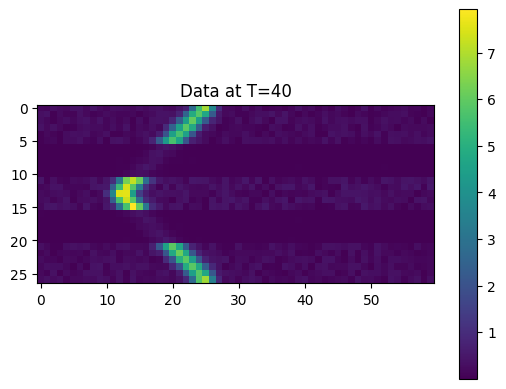

In [82]:
sample_time = 40
plt.imshow(deaths_TS[sample_time,:].reshape(data_shape))
plt.colorbar()
plt.title(f'Data at T={sample_time}')

In [83]:
nll_dist = best_nll_model(time_T,pop_S, lat_S, lon_S)

y_sample_TMS = nll_dist.sample((M_score_func,)).permute(1, 0, 2)
y_sample_action_TMS = y_sample_TMS

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
best_nll_r =  ratio_rating_TMS.mean(dim=1)

hybrid_dist = best_hybrid_model(time_T,pop_S, lat_S, lon_S)

y_sample_TMS = hybrid_dist.sample((M_score_func,)).permute(1, 0, 2)
y_sample_action_TMS = y_sample_TMS

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
best_hybrid_r =  ratio_rating_TMS.mean(dim=1)

bpr_dist = best_bpr_model(time_T,pop_S, lat_S, lon_S)

y_sample_TMS = bpr_dist.sample((M_score_func,)).permute(1, 0, 2)
y_sample_action_TMS = y_sample_TMS

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
best_bpr_r =  ratio_rating_TMS.mean(dim=1)

Text(0.5, 1.0, 'Best NLL Model at T=40')

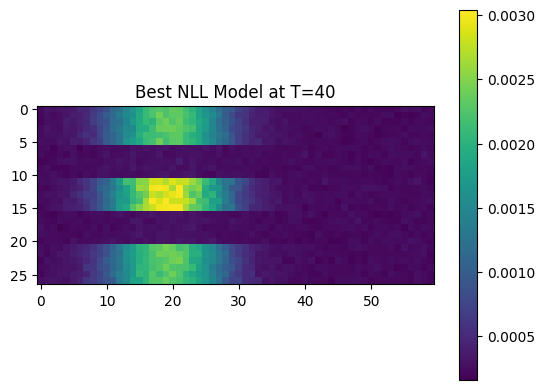

In [84]:
plt.imshow(best_nll_r.detach().numpy()[sample_time,:].reshape(27,60))
plt.colorbar()
plt.title(f'Best NLL Model at T={sample_time}')

Text(0.5, 1.0, 'Best Hybrid Model at T=40')

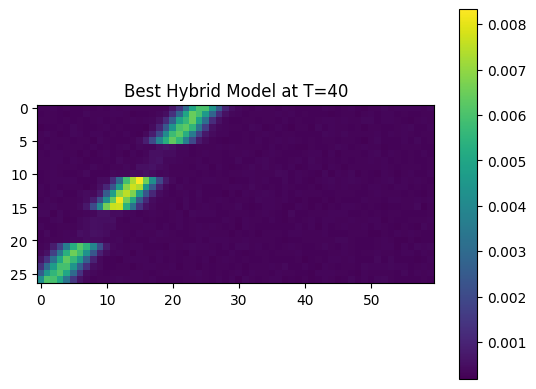

In [85]:
plt.imshow(best_hybrid_r.detach().numpy()[sample_time,:].reshape(27,60))
plt.colorbar()
plt.title(f'Best Hybrid Model at T={sample_time}')

Text(0.5, 1.0, 'Best BPR Model at T=40')

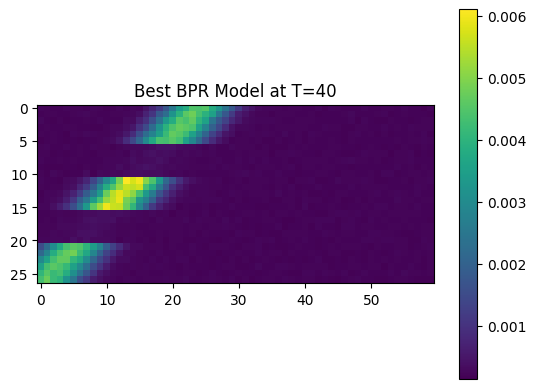

In [86]:
plt.imshow(best_bpr_r.detach().numpy()[sample_time,:].reshape(27,60))
plt.colorbar()
plt.title(f'Best BPR Model at T={sample_time}')

In [87]:
nll_arrival_speeds, nll_arrival_intercepts, nll_lat_coeff, nll_lon_coeff, nll_softplusinv_magnitudes, nll_softplusinv_peak_widths = best_nll_model.single_tensor_to_params(best_nll_model.params_to_single_tensor())
bpr_arrival_speeds, bpr_arrival_intercepts, bpr_lat_coeff, bpr_lon_coeff, bpr_softplusinv_magnitudes, bpr_softplusinv_peak_widths = best_bpr_model.single_tensor_to_params(best_bpr_model.params_to_single_tensor())
hybrid_arrival_speeds, hybrid_arrival_intercepts, hybrid_lat_coeff, hybrid_lon_coeff, hybrid_softplusinv_magnitudes, hybrid_softplusinv_peak_widths = best_hybrid_model.single_tensor_to_params(best_hybrid_model.params_to_single_tensor())

In [88]:
hybrid_arrival_speeds

tensor([0.5587], grad_fn=<SliceBackward0>)

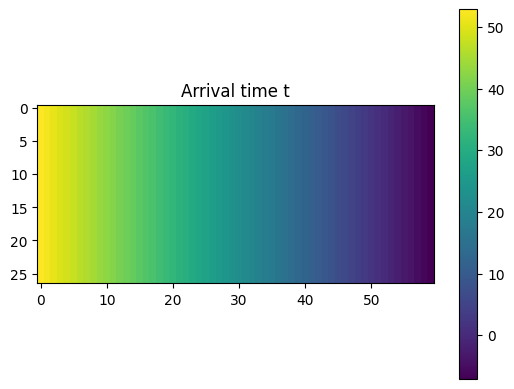

torch.Size([64, 1620, 1])


Text(0.5, 1.0, 'Prediction at time 40')

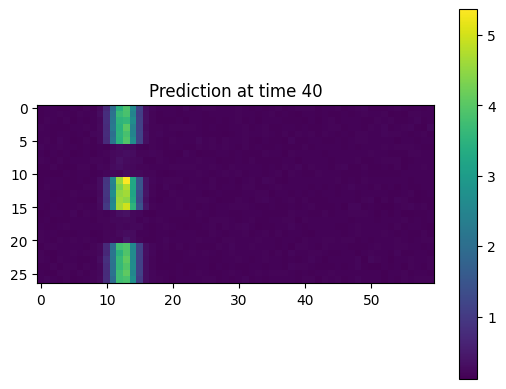

In [96]:
lon_coeff = torch.tensor([0.0,])
lat_coeff = torch.tensor([-1.0])
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
mag=0.005
width=2
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
plt.title('Arrival time t')
plt.imshow((arrival_intercept + lat_coeff*lat_S + lon_coeff*lon_S).view(data_shape))
plt.colorbar()
plt.show()

model = SpatialWaves(num_waves=1, low=0, high=100000, has_speed=False)
model.update_params(torch.cat([arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))

dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((M_score_func, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[sample_time,:].view(data_shape))
plt.colorbar()
plt.title(f'Prediction at time {sample_time}')

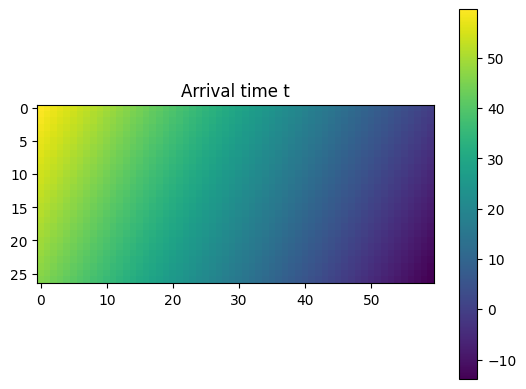

torch.Size([64, 1620, 1])


Text(0.5, 1.0, 'Prediction at time 40')

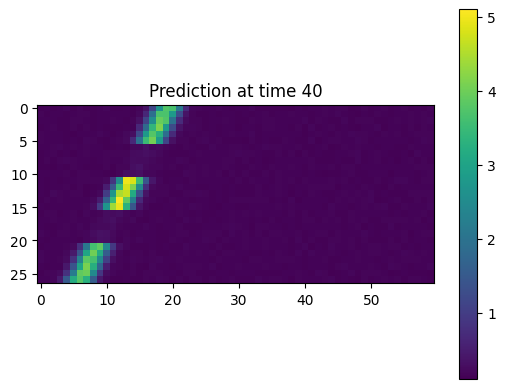

In [111]:
lon_coeff = torch.tensor([-0.5,])
lat_coeff = torch.tensor([-1])
arrival_intercept = torch.tensor([lat_S.view(data_shape)[0,52]]) 
mag=0.005
width=2
softinv_mags = torch.tensor([mag]) + torch.log(-torch.expm1(torch.tensor(-np.array([mag]))))
softinv_widths = torch.tensor([width]) + torch.log(-torch.expm1(torch.tensor(-np.array([width]))))
plt.title('Arrival time t')
plt.imshow((arrival_intercept + lat_coeff*lat_S + lon_coeff*lon_S).view(data_shape))
plt.colorbar()
plt.show()

model = SpatialWaves(num_waves=1, low=0, high=100000, has_speed=False)
model.update_params(torch.cat([arrival_intercept, lat_coeff, lon_coeff, softinv_mags, softinv_widths]))

dist = model(time_T,pop_S, lat_S, lon_S)
y_sample_TMS = dist.sample((M_score_func, )).permute(1, 0, 2)
plt.imshow(y_sample_TMS.mean(1)[sample_time,:].view(data_shape))
plt.colorbar()
plt.title(f'Prediction at time {sample_time}')

In [91]:
nll_arrival_intercepts

tensor([11.6631], grad_fn=<SliceBackward0>)

In [108]:
nll_softplusinv_peak_widths

tensor([3.6660], grad_fn=<SliceBackward0>)

In [109]:
bpr_softplusinv_peak_widths

tensor([2.2892], grad_fn=<SliceBackward0>)

In [110]:
hybrid_softplusinv_peak_widths

tensor([1.1624], grad_fn=<SliceBackward0>)